Data Profilling Cleaning and EDA for Sierraleone

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.projections import get_projection_class
import matplotlib.patches as mpatches

Load The Data

In [2]:

# Load the data
country = 'Sierra Leone'
file_path = 'C:/Users/hp/OneDrive/Desktop/kaim-ai/KAIM/ML-based-solar-data-discoveries/data/sierraleone-bumbuna.csv'
try:
    df = pd.read_csv(file_path, parse_dates=['Timestamp'])
    print(f"Successfully loaded data for {country}.")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Please check the path.")
    exit()  # Stop execution if the file is not found
except Exception as e:
    print(f"An error occurred while loading the data: {e}")
    exit()


Successfully loaded data for Sierra Leone.


Summary Statistics and Missing Value report

In [3]:

print("\nAn overview of the dataset and the shape of the dataset:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe())

# Calculate the percentage of missing values per column
print("\nMissing Value Report:")
missing_values = df.isnull().sum()
print(missing_values)

# Identify columns with > 5% nulls
total_rows = len(df)
null_percentage = (missing_values / total_rows) * 100
high_null_cols = null_percentage[null_percentage > 5].sort_values(ascending=False)
print("\nColumns with > 5% Missing Values:")
print(high_null_cols)

# Initial Inspection : to check potential incorrect entries
print("\nInitial Inspection of the dataset:")
print(df.head(5))


An overview of the dataset and the shape of the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525600 entries, 0 to 525599
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Timestamp      525600 non-null  datetime64[ns]
 1   GHI            525600 non-null  float64       
 2   DNI            525600 non-null  float64       
 3   DHI            525600 non-null  float64       
 4   ModA           525600 non-null  float64       
 5   ModB           525600 non-null  float64       
 6   Tamb           525600 non-null  float64       
 7   RH             525600 non-null  float64       
 8   WS             525600 non-null  float64       
 9   WSgust         525600 non-null  float64       
 10  WSstdev        525600 non-null  float64       
 11  WD             525600 non-null  float64       
 12  WDstdev        525600 non-null  float64       
 13  BP             525600 non-null  int64         

Outlier Detection and Basic Cleaning

In [4]:

# Handle Negative Values
cols_to_replace_negative = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB']
print("\nHandling Negative Values:")
for col in cols_to_replace_negative:
    if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
        print(f"  Column '{col}':")
        negative_count_before = len(df[df[col] < 0])
        print(f"    Number of negative values before: {negative_count_before}")
        df[col] = np.where(df[col] < 0, np.nan, df[col])  # Replace negative values with NaN
        negative_count_after = len(df[df[col] < 0])
        print(f"    Number of negative values after replacement: {negative_count_after}")
    else:
        print(f"  Warning: Column '{col}' not found or not numeric.")

# Z-score Calculation and Flagging
cols_to_check_zscore = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
print("\nZ-score Calculation and Outlier Flagging:")
for col in cols_to_check_zscore:
    if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
        df[f'{col}_ZScore'] = np.abs(stats.zscore(df[col], nan_policy='omit'))  # Handle NaNs in zscore
        df[f'{col}_Outlier'] = df[f'{col}_ZScore'] > 3
        print(f"  Column '{col}': {df[f'{col}_Outlier'].sum()} outliers (Z > 3)")
    else:
        print(f"  Warning: Column '{col}' not found or not numeric.")

# Create Cleaning Flag
df['Cleaning_Flag'] = False
cols_to_check = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']  # Corrected to include all relevant cols
for col in cols_to_check:
    if f'{col}_Outlier' in df.columns:
        df.loc[df[f'{col}_Outlier'], 'Cleaning_Flag'] = True

print(f"\nNumber of rows flagged for cleaning: {df['Cleaning_Flag'].sum()}")


# Handle Missing Values (Imputation with Median)
key_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust', 'Tamb']  # Add other key columns as needed.
print("\nHandling Missing Values by Imputation:")
for col in key_cols:
    if col in df.columns and df[col].isnull().any():
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
        print(f"  Column '{col}': Missing values imputed with median ({median_val:.2f})")
    elif col not in df.columns:
        print(f"  Warning: Key column '{col}' not found for imputation.")
    else:
        print(f"  Column '{col}': No missing values to impute.")

print("\nMissing values after imputation:")
print(df[key_cols].isnull().sum())

# Drop columns with more than 5% missing values
print("\nHandling Columns with High Missing Value Percentage:")
cols_to_drop = null_percentage[null_percentage > 5].index
cols_to_drop = [col for col in cols_to_drop if col in df.columns]  # <--- Added this line
if len(cols_to_drop) > 0:
    print(f"  Dropping columns with > 5% missing values: {list(cols_to_drop)}")
    df.drop(columns=cols_to_drop, inplace=True)
else:
    print("  No columns with > 5% missing values.")
print(f"  Remaining columns: {list(df.columns)}")

# Export Cleaned DataFrame
cleaned_file_path = 'C:/Users/hp/OneDrive/Desktop/kaim-ai/KAIM/ML-based-solar-data-discoveries/data/sierraleone-bumbuna_clean.csv'
try:
    df.to_csv(cleaned_file_path, index=False)
    print(f"\nCleaned DataFrame exported to {cleaned_file_path}")
except Exception as e:
    print(f"  Error exporting cleaned data: {e}")




Handling Negative Values:
  Column 'GHI':
    Number of negative values before: 261135
    Number of negative values after replacement: 0
  Column 'DNI':
    Number of negative values before: 266352
    Number of negative values after replacement: 0
  Column 'DHI':
    Number of negative values before: 263128
    Number of negative values after replacement: 0
  Column 'ModA':
    Number of negative values before: 0
    Number of negative values after replacement: 0
  Column 'ModB':
    Number of negative values before: 0
    Number of negative values after replacement: 0

Z-score Calculation and Outlier Flagging:
  Column 'GHI': 87 outliers (Z > 3)
  Column 'DNI': 0 outliers (Z > 3)
  Column 'DHI': 388 outliers (Z > 3)
  Column 'ModA': 1604 outliers (Z > 3)
  Column 'ModB': 2041 outliers (Z > 3)
  Column 'WS': 3967 outliers (Z > 3)
  Column 'WSgust': 3665 outliers (Z > 3)

Number of rows flagged for cleaning: 6943

Handling Missing Values by Imputation:


C:\Users\hp\AppData\Local\Temp\ipykernel_11004\542449379.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_val, inplace=True)
C:\Users\hp\AppData\Local\Temp\ipykernel_11004\542449379.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doi

  Column 'GHI': Missing values imputed with median (359.50)
  Column 'DNI': Missing values imputed with median (115.30)
  Column 'DHI': Missing values imputed with median (225.00)
  Column 'ModA': No missing values to impute.
  Column 'ModB': No missing values to impute.
  Column 'WS': No missing values to impute.
  Column 'WSgust': No missing values to impute.
  Column 'Tamb': No missing values to impute.

Missing values after imputation:
GHI       0
DNI       0
DHI       0
ModA      0
ModB      0
WS        0
WSgust    0
Tamb      0
dtype: int64

Handling Columns with High Missing Value Percentage:
  Dropping columns with > 5% missing values: ['Comments']
  Remaining columns: ['Timestamp', 'GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'Tamb', 'RH', 'WS', 'WSgust', 'WSstdev', 'WD', 'WDstdev', 'BP', 'Cleaning', 'Precipitation', 'TModA', 'TModB', 'GHI_ZScore', 'GHI_Outlier', 'DNI_ZScore', 'DNI_Outlier', 'DHI_ZScore', 'DHI_Outlier', 'ModA_ZScore', 'ModA_Outlier', 'ModB_ZScore', 'ModB_Outlier', 'WS

Time Series Analysis


Time Series Analysis:


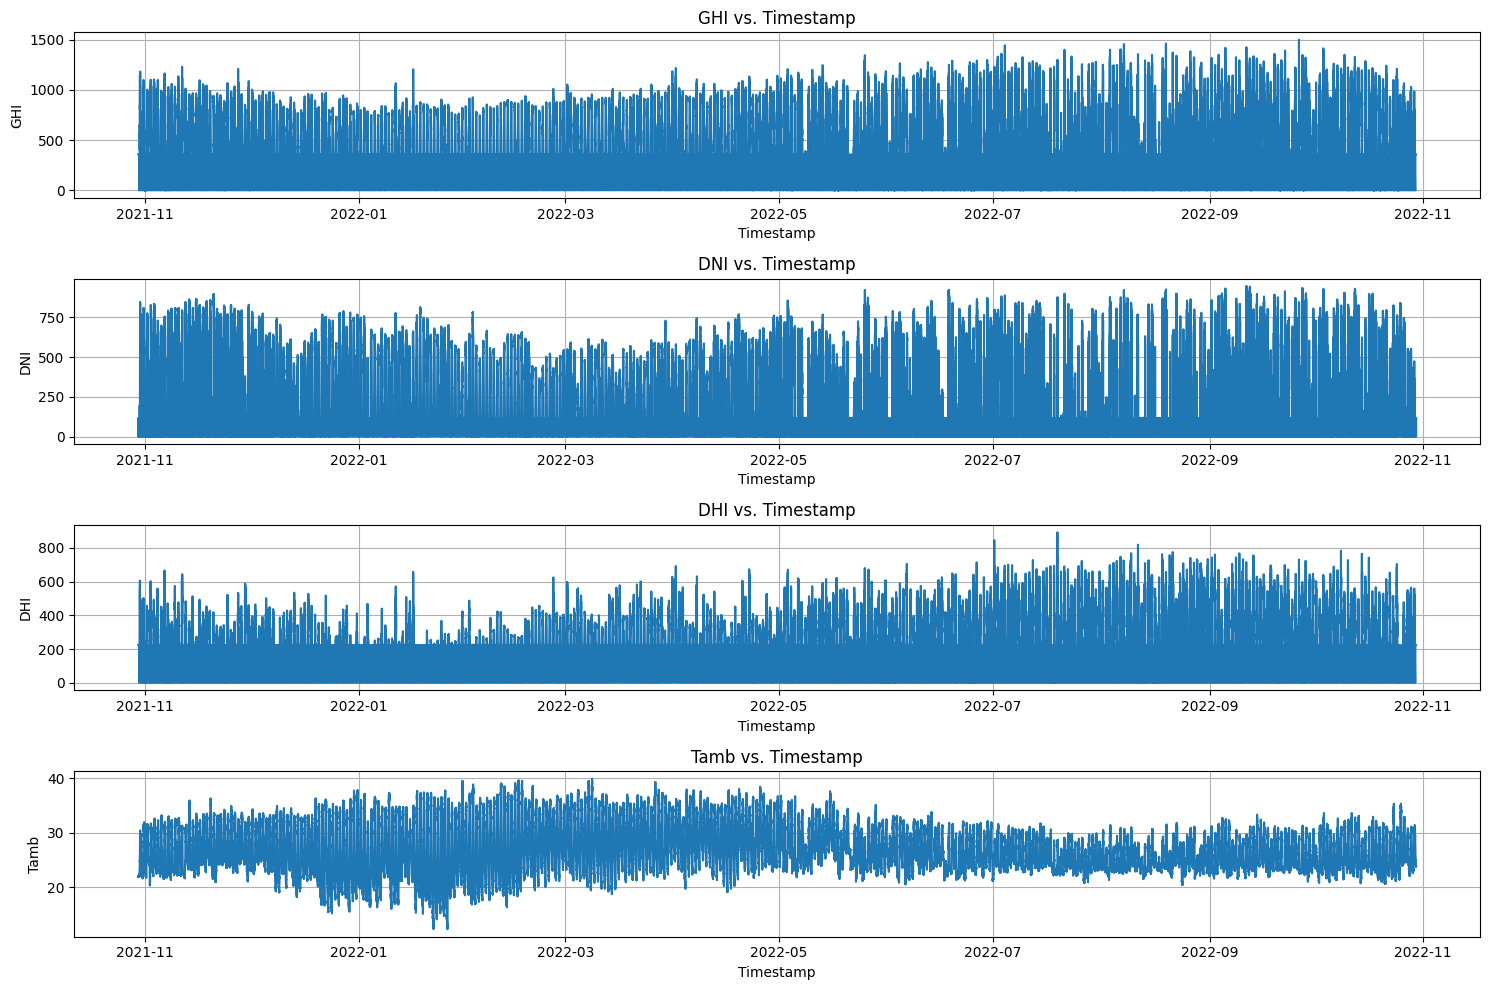

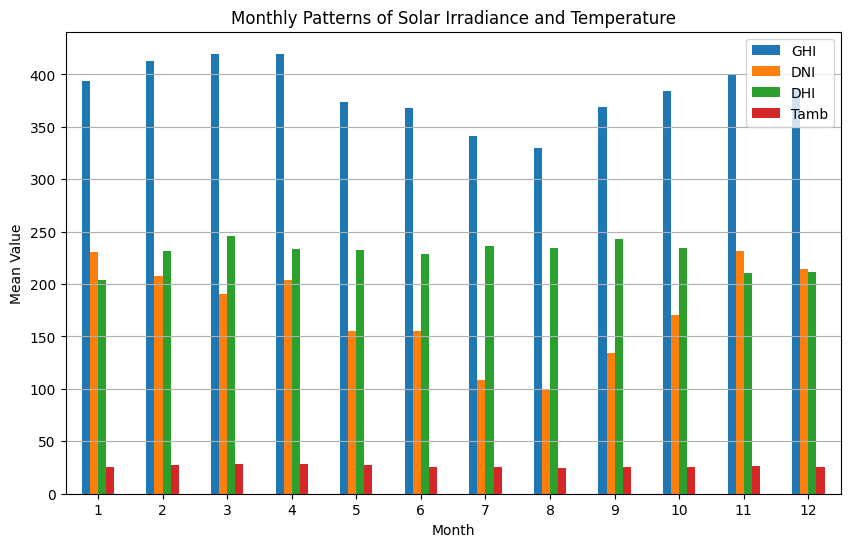

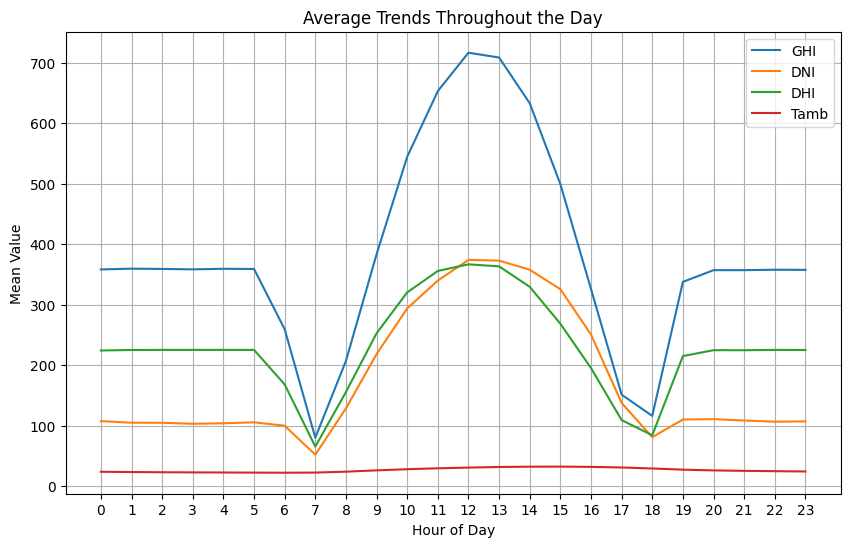

In [5]:

# Time Series Analysis
print("\nTime Series Analysis:")
time_series_cols = ['GHI', 'DNI', 'DHI', 'Tamb']
plt.figure(figsize=(15, 10))
for i, col in enumerate(time_series_cols):
    if col in df.columns and 'Timestamp' in df.columns:
        plt.subplot(len(time_series_cols), 1, i + 1)
        plt.plot(df['Timestamp'], df[col])
        plt.title(f'{col} vs. Timestamp')
        plt.xlabel('Timestamp')
        plt.ylabel(col)
        plt.grid(True)
    else:
        print(f"  Warning: Column '{col}' or 'Timestamp' not found for time series plot.")
plt.tight_layout()
plt.show()

# Patterns by Month
if 'Timestamp' in df.columns:
    df['Month'] = df['Timestamp'].dt.month
    monthly_patterns = df.groupby('Month')[time_series_cols].mean()
    monthly_patterns.plot(kind='bar', figsize=(10, 6))
    plt.title('Monthly Patterns of Solar Irradiance and Temperature')
    plt.ylabel('Mean Value')
    plt.xlabel('Month')
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.show()
else:
    print("  Warning: 'Timestamp' column not found for monthly analysis.")

# Trends Throughout Day
if 'Timestamp' in df.columns:
    df['Hour'] = df['Timestamp'].dt.hour
    hourly_patterns = df.groupby('Hour')[time_series_cols].mean()
    hourly_patterns.plot(kind='line', figsize=(10, 6))
    plt.title('Average Trends Throughout the Day')
    plt.ylabel('Mean Value')
    plt.xlabel('Hour of Day')
    plt.xticks(range(24))
    plt.grid(True)
    plt.show()
else:
    print("  Warning: 'Timestamp' column not found for daily analysis.")



 Cleaning Impact Analysis


Cleaning Impact Analysis:

Average ModA & ModB values, and counts, pre/post cleaning
                     ModA                ModB        
                     mean   count        mean   count
Cleaning_Flag                                        
False          202.218541  518657  193.788571  518657
True           537.166758    6943  521.285179    6943


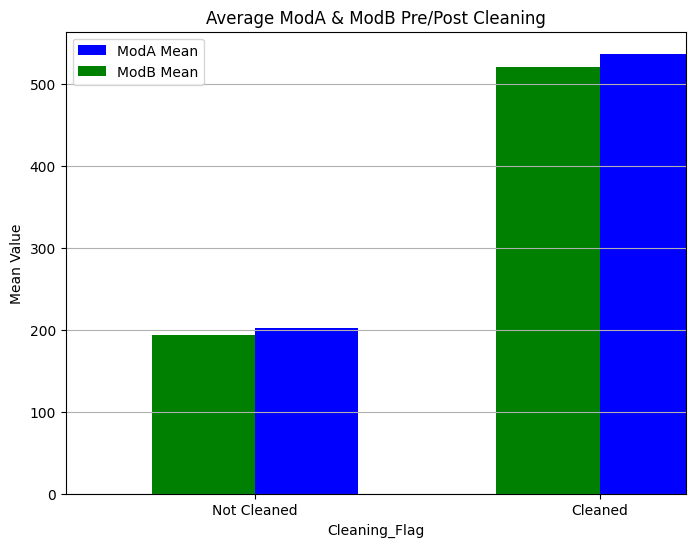

In [6]:


# Cleaning Impact Analysis
print("\nCleaning Impact Analysis:")
if 'Cleaning_Flag' in df.columns and 'ModA' in df.columns and 'ModB' in df.columns:
    cleaning_impact = df.groupby('Cleaning_Flag')[['ModA', 'ModB']].agg(['mean', 'count'])
    print("\nAverage ModA & ModB values, and counts, pre/post cleaning")
    print(cleaning_impact)

    # Create the plot
    plt.figure(figsize=(8, 6))
    cleaning_impact['ModA']['mean'].plot(kind='bar', position=0, width=0.3, label='ModA Mean', color='blue')
    cleaning_impact['ModB']['mean'].plot(kind='bar', position=1, width=0.3, label='ModB Mean', color='green')
    plt.xticks([0, 1], ['Not Cleaned', 'Cleaned'], rotation=0)
    plt.ylabel('Mean Value')
    plt.title('Average ModA & ModB Pre/Post Cleaning')
    plt.legend()
    plt.grid(axis='y')
    plt.show()
else:
    print("  Warning: 'Cleaning_Flag', 'ModA', or 'ModB' columns not found for cleaning impact analysis.")



Correlation and Relationship Analysis


Correlation and Relationship Analysis
  Columns in DataFrame: Index(['Timestamp', 'GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'Tamb', 'RH', 'WS',
       'WSgust', 'WSstdev', 'WD', 'WDstdev', 'BP', 'Cleaning', 'Precipitation',
       'TModA', 'TModB', 'GHI_ZScore', 'GHI_Outlier', 'DNI_ZScore',
       'DNI_Outlier', 'DHI_ZScore', 'DHI_Outlier', 'ModA_ZScore',
       'ModA_Outlier', 'ModB_ZScore', 'ModB_Outlier', 'WS_ZScore',
       'WS_Outlier', 'WSgust_ZScore', 'WSgust_Outlier', 'Cleaning_Flag',
       'Month', 'Hour'],
      dtype='object')


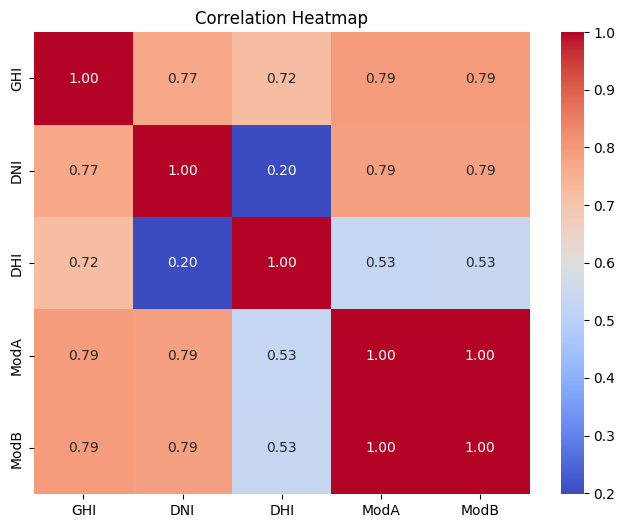

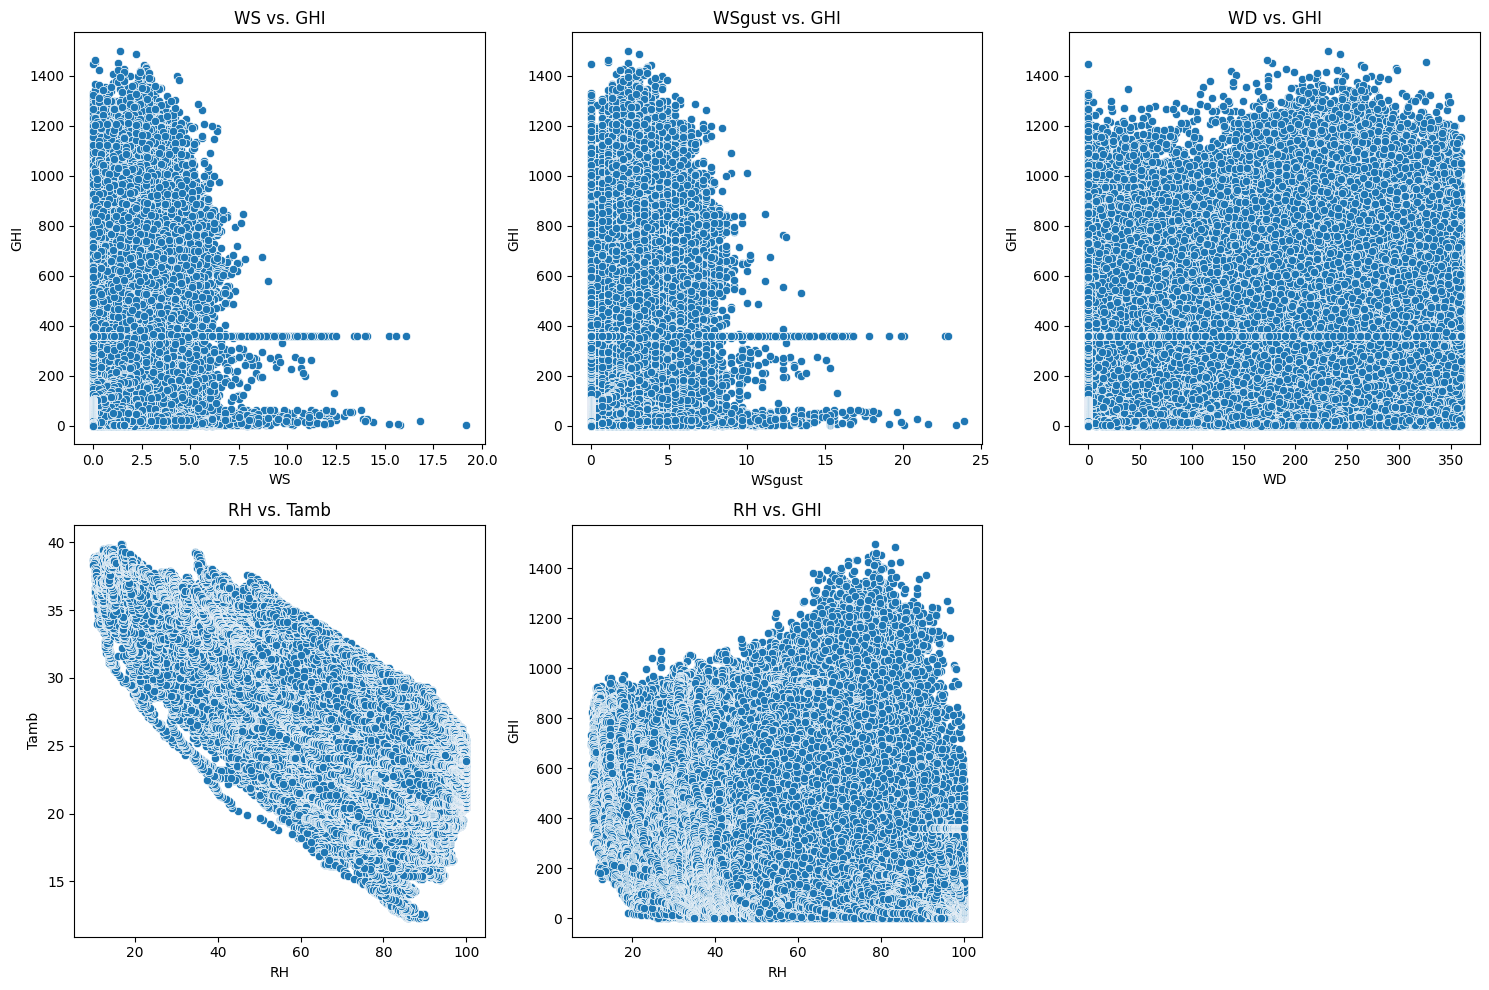

In [7]:

# Correlation and Relationship Analysis
print("\nCorrelation and Relationship Analysis")
# Print the columns in the DataFrame
print("  Columns in DataFrame:", df.columns)
# Heatmap of correlations
corr_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB']
if all(col in df.columns for col in corr_cols):
    corr_matrix = df[corr_cols].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Heatmap')
    plt.show()
else:
    print("  Warning: Not all of ['GHI', 'DNI', 'DHI', 'ModA', 'ModB'] found for correlation heatmap.")

# Scatter plots
scatter_pairs = [('WS', 'GHI'), ('WSgust', 'GHI'), ('WD', 'GHI'), ('RH', 'Tamb'), ('RH', 'GHI')]
plt.figure(figsize=(15, 10))
for i, (col1, col2) in enumerate(scatter_pairs):
    if col1 in df.columns and col2 in df.columns:
        plt.subplot(2, 3, i + 1)
        sns.scatterplot(x=df[col1], y=df[col2])
        plt.title(f'{col1} vs. {col2}')
        plt.xlabel(col1)
        plt.ylabel(col2)
    else:
        print(f"  Warning: One or both columns ('{col1}', '{col2}') not found for scatter plot.")
plt.tight_layout()
plt.show()

Wind and Distribution Analysis


Wind & Distribution Analysis


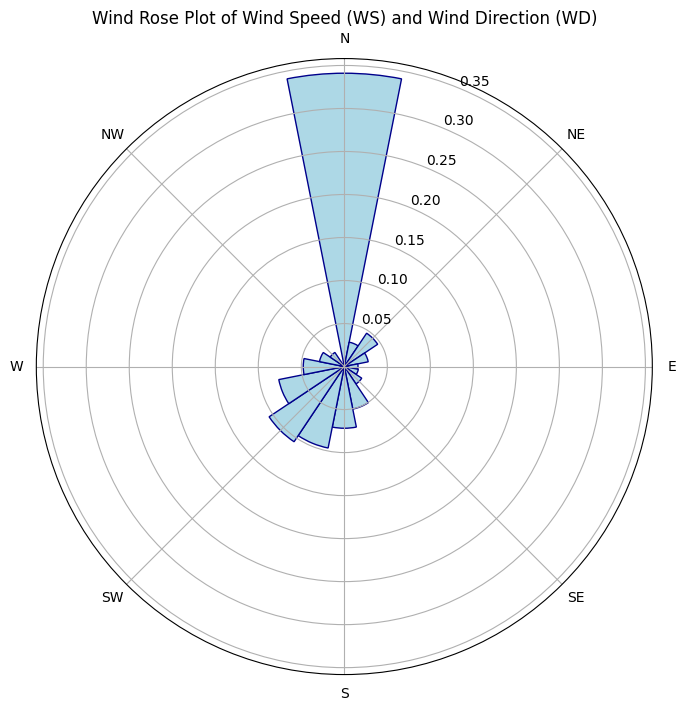

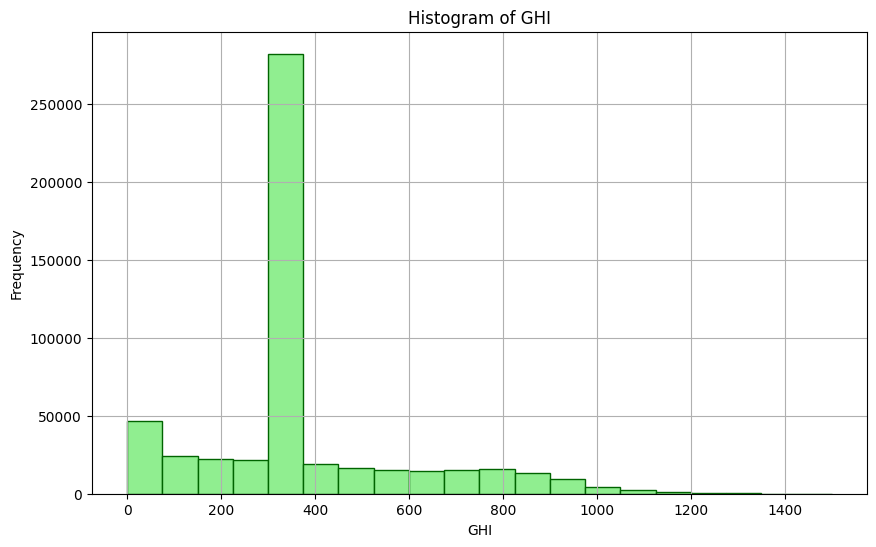

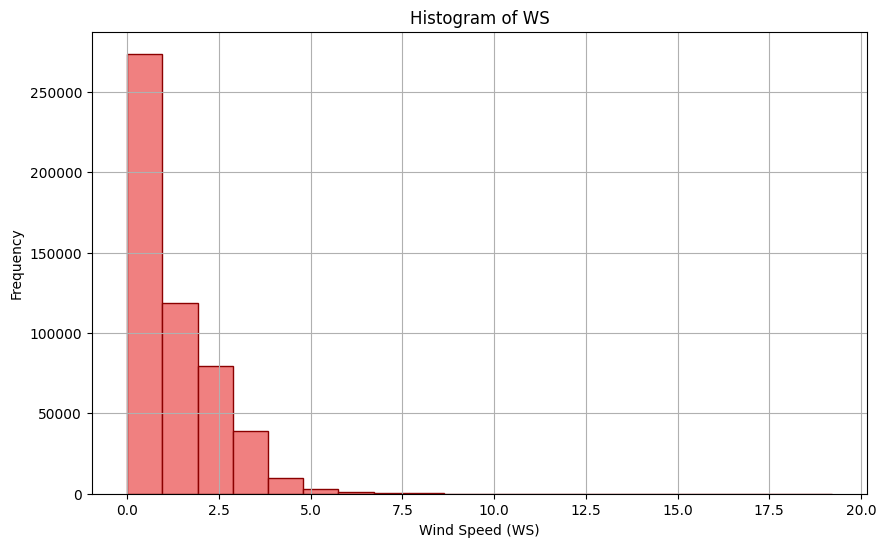

In [8]:

# Wind & Distribution Analysis
print("\nWind & Distribution Analysis")
if 'WS' in df.columns and 'WD' in df.columns:
    # Wind Rose Plot
    fig = plt.figure(figsize=(8, 8))  # Create the figure first
    ax = fig.add_subplot(1, 1, 1, projection='polar')  # Add a polar subplot
    # Convert wind direction to radians
    wd_rad = np.deg2rad(df['WD'])
    # Create bins for wind direction
    bins = np.arange(0, 360, 22.5)
    # Calculate the frequency of wind directions
    counts, _ = np.histogram(df['WD'], bins=bins)
    # Normalize the counts
    counts = counts / counts.sum()
    # Define the width of each bin in radians
    width = np.deg2rad(360 / len(bins))
    # Plot the bar for each wind direction
    bars = ax.bar(np.deg2rad(bins[:-1]), counts, width=width, bottom=0.0, color='lightblue', edgecolor='darkblue')
    # Set the direction labels
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    # Set the tick labels for the wind directions
    ax.set_xticks(np.deg2rad(np.arange(0, 360, 45)))
    ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
    ax.set_title('Wind Rose Plot of Wind Speed (WS) and Wind Direction (WD)')
    plt.show()
else:
    print("  Warning: 'WS' or 'WD' not found for wind rose plot.")

if 'GHI' in df.columns:
    # Histograms for GHI
    plt.figure(figsize=(10, 6))
    plt.hist(df['GHI'], bins=20, color='lightgreen', edgecolor='darkgreen')
    plt.title('Histogram of GHI')
    plt.xlabel('GHI')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
else:
    print("  Warning: 'GHI' not found for histogram.")

if 'WS' in df.columns:
    # Histogram for WS
    plt.figure(figsize=(10, 6))
    plt.hist(df['WS'], bins=20, color='lightcoral', edgecolor='darkred')
    plt.title('Histogram of WS')
    plt.xlabel('Wind Speed (WS)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
else:
    print("  Warning: 'WS' not found for histogram.")


Temperature Analysis


Temperature Analysis


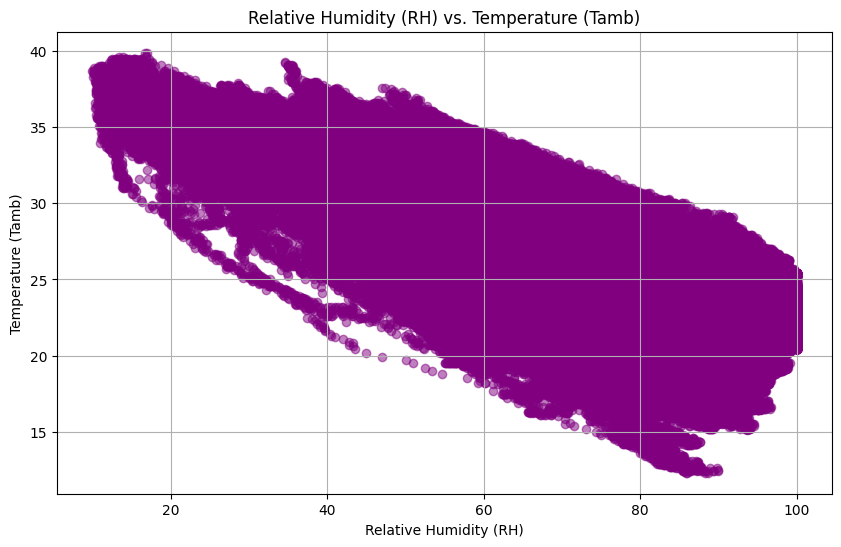

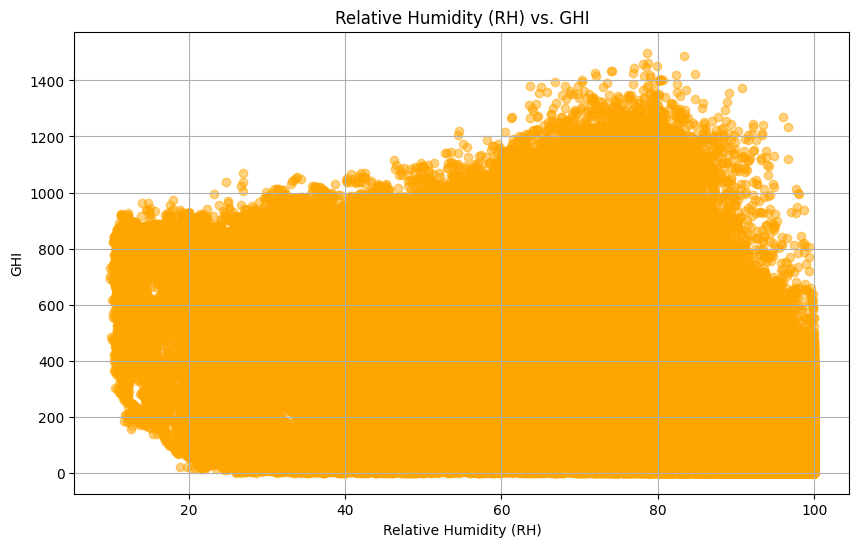

In [9]:

# Temperature Analysis
print("\nTemperature Analysis")
if 'RH' in df.columns and 'Tamb' in df.columns and 'GHI' in df.columns:
    plt.figure(figsize=(10, 6))
    plt.scatter(df['RH'], df['Tamb'], alpha=0.5, color='purple')
    plt.title('Relative Humidity (RH) vs. Temperature (Tamb)')
    plt.xlabel('Relative Humidity (RH)')
    plt.ylabel('Temperature (Tamb)')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.scatter(df['RH'], df['GHI'], alpha=0.5, color='orange')
    plt.title('Relative Humidity (RH) vs. GHI')
    plt.xlabel('Relative Humidity (RH)')
    plt.ylabel('GHI')
    plt.grid(True)
    plt.show()
else:
    print("  Warning: 'RH', 'Tamb', or 'GHI' not found for temperature analysis.")


Bubble Chart

In [ ]:

# Bubble Chart
print("\nBubble Chart")
if 'GHI' in df.columns and 'Tamb' in df.columns and 'RH' in df.columns:
    plt.figure(figsize=(10, 6))
    plt.scatter(df['GHI'], df['Tamb'], s=df['RH'] * 5, alpha=0.5, color='royalblue')
    plt.title('GHI vs. Tamb with Bubble Size = RH')
    plt.xlabel('GHI')
    plt.ylabel('Temperature (Tamb)')
    plt.grid(True)
    # Add a legend for the bubble size
    sizes = [df['RH'].min() * 5, df['RH'].median() * 5, df['RH'].max() * 5]
    labels = ['Low RH', 'Medium RH', 'High RH']
    for size, label in zip(sizes, labels):
        plt.scatter([], [], s=size, alpha=0.5, color='royalblue', label=label)
    plt.legend(scatterpoints=1, labelspacing=1, title='RH')
    plt.show()
else:
    print("  Warning: 'GHI', 'Tamb', or 'RH' not found for bubble chart.")



Bubble Chart


c:\Users\hp\OneDrive\Desktop\kaim-ai\KAIM\ML-based-solar-data-discoveries\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
